<a href="https://colab.research.google.com/github/SemyonYakovlev/SemyonYakovlev/blob/main/Yakovlev_AAPL_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 6.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=220e324370e289b2f3b0941188d30687e0bd8b3b8d0ceb213e5480a77cb7148a
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from keras.layers import LSTM
import numpy as np 
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = yf.download('AAPL','2016-01-01')
df = df.drop(columns=['Open', 'High', 'Close', 'Low','Volume'])
df

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2016-01-04,24.323219
2016-01-05,23.713696
2016-01-06,23.249626
2016-01-07,22.268383
2016-01-08,22.386133
...,...
2021-05-18,124.849998
2021-05-19,124.690002
2021-05-20,127.309998


In [ ]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [ ]:
df

array([[0.02651734],
       [0.02150504],
       [0.01768885],
       ...,
       [0.87341017],
       [0.85795036],
       [0.87513624]])

In [ ]:

train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [ ]:
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [ ]:
look_back = 60
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 5, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/5
60/60 [==============================] - 13s 122ms/step - loss: 5.2537e-04 - val_loss: 0.1306
Epoch 2/5
60/60 [==============================] - 6s 93ms/step - loss: 0.0051 - val_loss: 0.1194
Epoch 3/5
60/60 [==============================] - 6s 96ms/step - loss: 0.0120 - val_loss: 0.1772
Epoch 4/5
60/60 [==============================] - 6s 104ms/step - loss: 0.0059 - val_loss: 0.0469
Epoch 5/5
60/60 [==============================] - 8s 136ms/step - loss: 0.0035 - val_loss: 0.0033


In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [ ]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

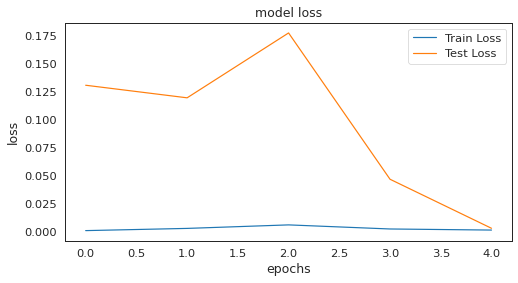

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

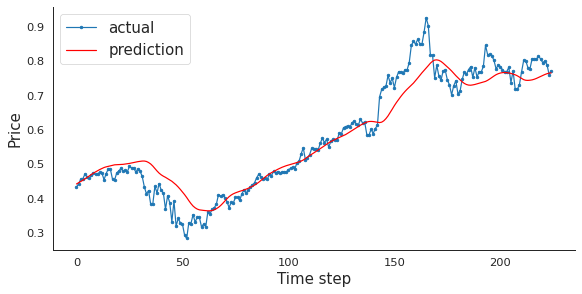

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(225)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:225], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:225], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();